# GlueStick Image Matching Demo 🖼️💥🖼️


In this python notebook we show how to obtain point and line matches using GlueStick. GlueStick is a unified pipeline that uses a single GNN to process both types of features and predicts coherent point and line matched that help each other in the matching process.

![](https://iago-suarez.com/gluestick/static/images/method_overview2.svg)

If you use this python notebook please cite our work:

> Pautrat, R.* and Suárez, I.* and Yu, Y. and Pollefeys, M. and Larsson, V. (2023). "GlueStick: Robust Image Matching by Sticking Points and Lines Together". ArXiv preprint.

In [529]:
# # Download the repository
# !git clone https://github.com/cvg/GlueStick.git
# %cd GlueStick

In [530]:
# Install requirements
# !pip install -r requirements.txt

Download the pre-trained model

In [531]:
# !wget https://github.com/cvg/GlueStick/releases/download/v0.1_arxiv/checkpoint_GlueStick_MD.tar -P resources/weights

In [532]:
from os.path import join

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt


from gluestick import batch_to_np, numpy_image_to_torch, GLUESTICK_ROOT
from gluestick.drawing import plot_images, plot_lines, plot_color_line_matches, plot_keypoints, plot_matches
from gluestick.models.two_view_pipeline import TwoViewPipeline

Define the configuration and model that we are going to use in our demo:

In [533]:
MAX_N_POINTS, MAX_N_LINES = 1000, 300

# Evaluation config
conf = {
    'name': 'two_view_pipeline',
    'use_lines': True,
    'extractor': {
        'name': 'wireframe',
        'sp_params': {
            'force_num_keypoints': False,
            'max_num_keypoints': MAX_N_POINTS,
        },
        'wireframe_params': {
            'merge_points': True,
            'merge_line_endpoints': True,
        },
        'max_n_lines': MAX_N_LINES,
    },
    'matcher': {
        'name': 'gluestick',
        'weights': str(GLUESTICK_ROOT / 'resources' / 'weights' / 'checkpoint_GlueStick_MD.tar'),
        'trainable': False,
    },
    'ground_truth': {
        'from_pose_depth': False,
    }
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline_model = TwoViewPipeline(conf).to(device).eval()
pipeline_model

TwoViewPipeline(
  (extractor): SPWireframeDescriptor(
    (sp): SuperPoint(
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPb): Conv2d(256, 65, kernel_size=(1, 1), str

In [534]:
# Load input images
import sys

# img_path0 = "/media/colin/DATA/exp_office_cieling/matlab_clahe2_rect_appx/1697668704578459277.png"
# img_path1 = "/media/colin/DATA/exp_office_cieling/matlab_clahe2_rect_appx/1697668704645165036.png"

img_path0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/1689805041743999958.png"
# img_path0 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819946857000113.png"
img_path1 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819945923000097.png"
# img_path1 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819953789999962.png"

img_path0 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819868072999954.png"
img_path1 = "/media/colin/box_data/ir_data/nuance_data/kri_night/cam_3/matlab_clahe2/1689819868105999947.png"

# IN_COLAB = 'google.colab' in sys.modules
# if not IN_COLAB:
#     # We are running a notebook in Jupyter
#     img_path0 = join('resources', 'img1.jpg')
#     img_path1 = join('resources', 'img2.jpg')
# else:
#     # We are running in Colab: Load from user's disk using Colab tools
#     from google.colab import files
#     print('Choose the FIRST image from your computer (Recommended resolution: 640x640)')
#     uploaded_files = files.upload()
#     img_path0 = list(uploaded_files.keys())[0]
#     print('Choose the SECOND image from your computer')
#     uploaded_files = files.upload()
#     img_path1 = list(uploaded_files.keys())[0]

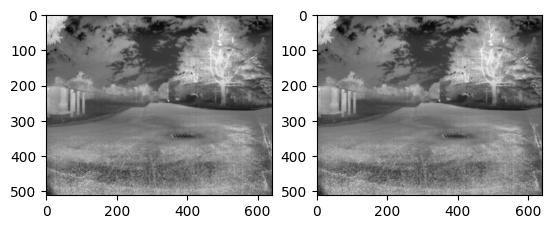

In [535]:
img = cv2.imread(img_path0, cv2.IMREAD_GRAYSCALE)

gray0 = cv2.imread(img_path0, 0)
gray1 = cv2.imread(img_path1, 0)

# Plot them using matplotlib
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gray0, cmap='gray')
axarr[1].imshow(gray1, cmap='gray')

In [536]:
# Convert images into torch and execute GlueStick💥

torch_gray0, torch_gray1 = numpy_image_to_torch(gray0), numpy_image_to_torch(gray1)
torch_gray0, torch_gray1 = torch_gray0.to(device)[None], torch_gray1.to(device)[None]
x = {'image0': torch_gray0, 'image1': torch_gray1}
pred = pipeline_model(x)
print(pred.keys())

dict_keys(['keypoints0', 'keypoint_scores0', 'descriptors0', 'pl_associativity0', 'num_junctions0', 'lines0', 'orig_lines0', 'lines_junc_idx0', 'line_scores0', 'valid_lines0', 'keypoints1', 'keypoint_scores1', 'descriptors1', 'pl_associativity1', 'num_junctions1', 'lines1', 'orig_lines1', 'lines_junc_idx1', 'line_scores1', 'valid_lines1', 'log_assignment', 'matches0', 'matches1', 'match_scores0', 'match_scores1', 'line_log_assignment', 'line_matches0', 'line_matches1', 'line_match_scores0', 'line_match_scores1', 'raw_line_scores'])


In [537]:
print(f"Detected Keypoints: {pred['keypoints0'].shape[1]} img1, {pred['keypoints1'].shape[1]} img2")
print(f"Detected Lines: {pred['lines0'].shape[1]} img1, {pred['lines1'].shape[1]} img2\n")
print(f"Matched {(pred['matches0'] >= 0).sum()} points and {(pred['line_matches0'] >= 0).sum()} lines")

Detected Keypoints: 802 img1, 798 img2
Detected Lines: 64 img1, 65 img2

Matched 724 points and 56 lines


Show some matches

In [538]:
# print(pred.keys())
# print(pred["descriptors0"].shape)
# print(pred)
pred = batch_to_np(pred)
kp0, kp1 = pred["keypoints0"], pred["keypoints1"]
desc0, desc1 = pred['descriptors0'].T, pred['descriptors1'].T
m0 = pred["matches0"]

line_seg0, line_seg1 = pred["lines0"], pred["lines1"]
line_matches = pred["line_matches0"]

valid_matches = m0 != -1
match_indices = m0[valid_matches]
matched_kps0 = kp0[valid_matches]
matched_kps1 = kp1[match_indices]

valid_matches = line_matches != -1
match_indices = line_matches[valid_matches]
matched_lines0 = line_seg0[valid_matches]
matched_lines1 = line_seg1[match_indices]

# print(matched_lines0)
# print(matched_lines0)

def parse_lines(kps, lines, desc):
    '''Turns out to just duplicate the index provided by "lines_junc_idx0"'''
    line_kp_idx = np.empty(lines.shape[:2], dtype = int)
    # line_descs = []
    line_descs = np.empty((len(lines), 2, desc.shape[-1]), dtype = np.float32)

    for i, line in enumerate(lines):
        #seach for line end point in kps
        line_end_pt_0 = line[0]
        line_end_pt_1 = line[1]

        kp_match_0 = np.logical_and.reduce(kps == line_end_pt_0, axis = -1)
        kp_match_1 = np.logical_and.reduce(kps == line_end_pt_1, axis = -1)

        end_pt_desc_0 = desc[kp_match_0].reshape(-1)
        end_pt_desc_1 = desc[kp_match_1].reshape(-1)
        assert(len(end_pt_desc_0) == 256)
        assert(len(end_pt_desc_1) == 256)
        line_descs[i,0,:] = end_pt_desc_0
        line_descs[i,1,:] = end_pt_desc_1

        end_pt_0_kp_idx = np.nonzero(kp_match_0)[0]
        end_pt_1_kp_idx = np.nonzero(kp_match_1)[0]
        assert(len(end_pt_0_kp_idx) == 1)
        assert(len(end_pt_1_kp_idx) == 1)
        # print(end_pt_0_kp_idx)
        # print(end_pt_1_kp_idx)
        line_kp_idx[i,0] = end_pt_0_kp_idx[0]
        line_kp_idx[i,1] = end_pt_1_kp_idx[0]
        # raise 

    return line_kp_idx, line_descs

def get_line_descriptors(descriptors, line_junc_idx):
    '''return array of line descriptors'''
    line_descs = np.empty((line_junc_idx.shape[0], line_junc_idx.shape[1], 256), dtype = np.float32)
    for i, line in enumerate(line_junc_idx):
        line_descs[i,0,:] = descriptors[line[0]]
        line_descs[i,1,:] = descriptors[line[1]]
    return line_descs

lines_junc_idx0 = pred['lines_junc_idx0']

ld = get_line_descriptors(desc0, lines_junc_idx0)
print(ld)
# line_kp0 = matched_lines0[0,0]
# print(line_kp0)
# print(line_kp0 in kp0)
# print(kp0[0])
# print(kp0[1])
# print(line_seg0[0])
# line_kp_idx, line_descs = parse_lines(kp0, line_seg0, desc0)
# print(len(line_kp_idx))
# # print(len())
# print(len(kp0))
# print(np.logical_and.reduce(kp0 == line_kp0, axis = -1))
# print(np.where(np.logical_and.reduce(kp0 == line_kp0, axis = -1)))
# print(np.nonzero(np.logical_and.reduce(kp0 == line_kp0, axis = -1)))
# print(len(matched_lines0))
# print(len(line_seg0))
#'pl_associativity0', 'num_junctions0', 'lines0', 'orig_lines0', 'lines_junc_idx0', 'line_scores0', 'valid_lines0'
# print(pred['pl_associativity0'])
# print(pred['num_junctions0'])
# print(pred['lines_junc_idx0'])
# print(pred('pl_associativity0'))
# print(pred('pl_associativity0'))

[[[ 0.0188209  -0.00131151  0.00524376 ... -0.01154963  0.06569096
    0.04039118]
  [-0.02092684  0.1771693  -0.10067526 ... -0.03745512  0.10051096
    0.08953707]]

 [[ 0.01859828 -0.16925718 -0.00231415 ... -0.06097747 -0.09144
   -0.03474031]
  [-0.05217043  0.0496007  -0.01811271 ... -0.02725176 -0.02225471
    0.03440561]]

 [[-0.07162515  0.0482742  -0.03985284 ... -0.02090872 -0.03394871
    0.00113254]
  [ 0.00733113 -0.17904983 -0.02074401 ... -0.10305231 -0.09979414
   -0.00778741]]

 ...

 [[-0.01863667 -0.11772566  0.00996615 ...  0.00952889 -0.10813195
   -0.02138426]
  [-0.02403399 -0.08318068  0.02066056 ...  0.08298957 -0.12384329
   -0.07455819]]

 [[-0.0299294   0.02088903 -0.02204277 ... -0.05286203  0.04285363
    0.01483115]
  [-0.02647287  0.10250691  0.02820363 ... -0.00913061 -0.07795969
   -0.06386574]]

 [[-0.03556521 -0.08315998  0.05361057 ...  0.02996177 -0.03015377
    0.01046798]
  [-0.07104737 -0.11499322  0.04252969 ...  0.07036024 -0.09154675
    0.0

## Detected Lines

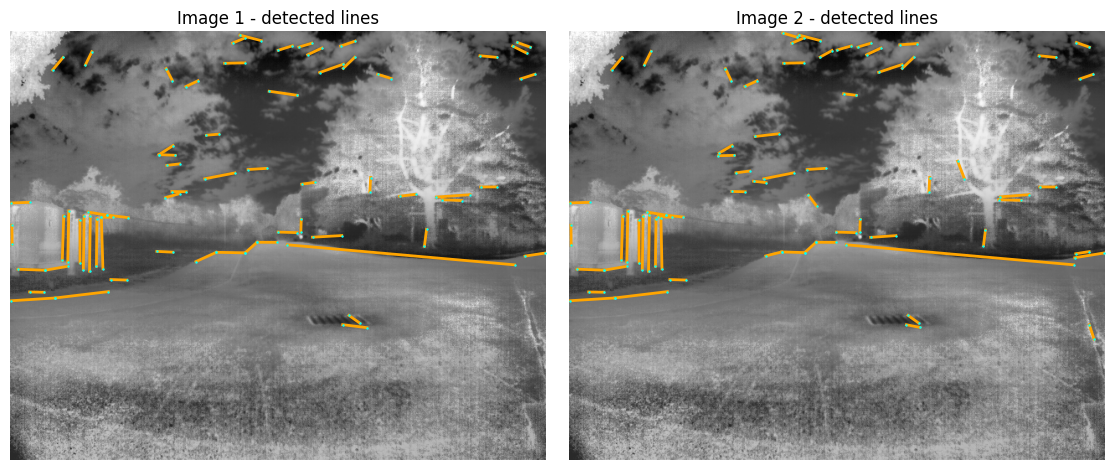

In [539]:
img0, img1 = cv2.cvtColor(gray0, cv2.COLOR_GRAY2BGR), cv2.cvtColor(gray1, cv2.COLOR_GRAY2BGR)
plot_images([img0, img1], ['Image 1 - detected lines', 'Image 2 - detected lines'], pad=0.5)
plot_lines([line_seg0, line_seg1], ps=3, lw=2)

## Detected Points

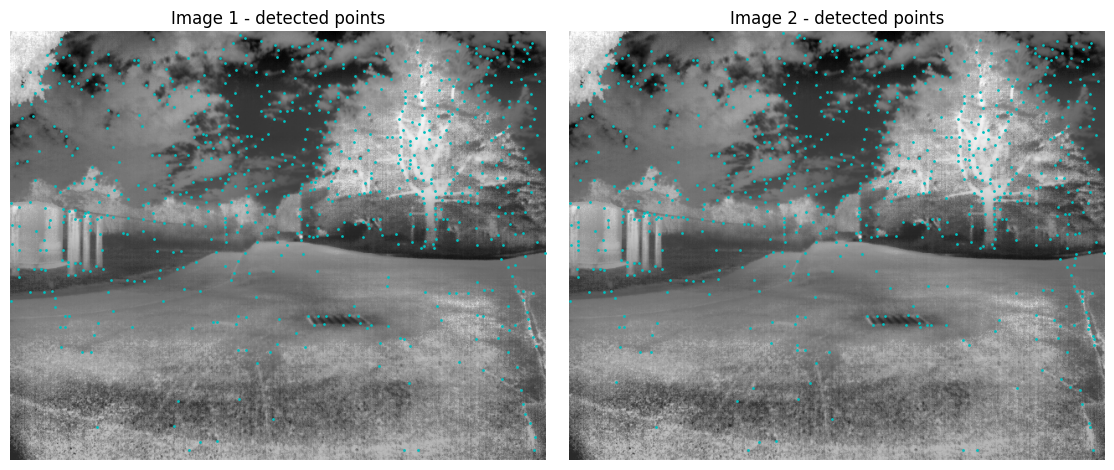

In [540]:
plot_images([img0, img1], ['Image 1 - detected points', 'Image 2 - detected points'], pad=0.5)
plot_keypoints([kp0, kp1], colors='c')

## Matched Lines
(Each match has a different color)

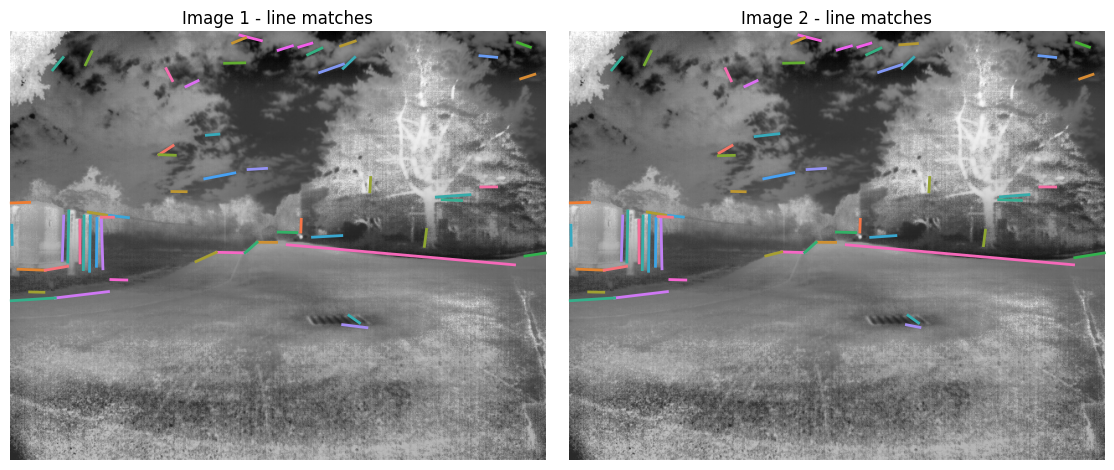

In [541]:
plot_images([img0, img1], ['Image 1 - line matches', 'Image 2 - line matches'], pad=0.5)
plot_color_line_matches([matched_lines0, matched_lines1], lw=2)

## Matched Points

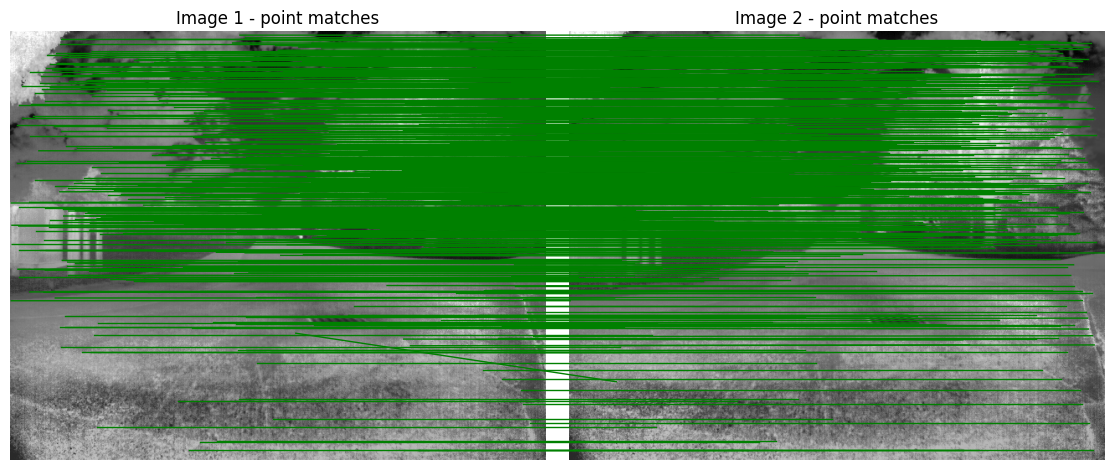

In [542]:
plot_images([img0, img1], ['Image 1 - point matches', 'Image 2 - point matches'], pad=0.5)
plot_matches(matched_kps0, matched_kps1, 'green', lw=1, ps=0)

# Homography estimation

If the scene is nearly a plane, we can estimate a robust homography using both, points and lines

In [543]:
# !sudo apt-get update
# !sudo apt-get install -y libceres-dev libeigen3-dev
# !pip install git+https://github.com/rpautrat/homography_est.git@17b200d528e6aa8ac61a878a29265bf5f9d36c41

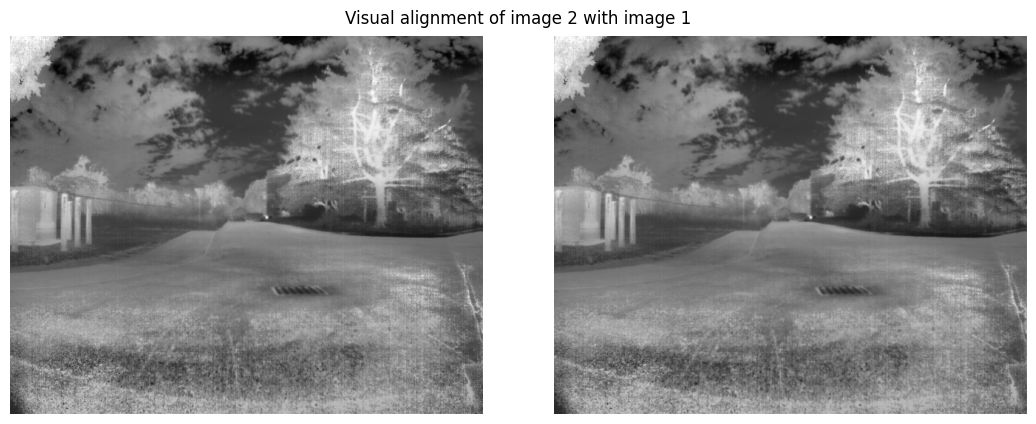

In [544]:
import homography_est as hest

line_seg0 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines0.reshape(-1, 2, 2)]
line_seg1 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines1.reshape(-1, 2, 2)]

tol_px = 1.0
H = hest.ransac_point_line_homography(matched_kps0, matched_kps1, line_seg0, line_seg1, tol_px, False, [], [])

color0 = cv2.cvtColor(cv2.imread(img_path0), cv2.COLOR_BGR2RGBA)
color1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGBA)

warped = cv2.warpPerspective(color1, H, color0.shape[:2][::-1])

plot_images([color0, warped], pad=2.6)
plt.suptitle('Visual alignment of image 2 with image 1')
plt.show()

We can check how well aligned are both images generating a nice transition GIF 😎

In [545]:
# #@title GIF Generation
# import matplotlib.animation as animation
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
# import sys
# from IPython.display import Video

# n_frames = 10
# # create samples distribution with different `std` values
# frames_indices = np.append(np.arange(n_frames), np.arange(n_frames)[::-1])
# pbar = tqdm(frames_indices, desc ="Generating animation", total=len(frames_indices)-1)
# # func which will be applied in order to create a video frame
# def func(i):
#     plt.gca().clear()
#     alpha = i / (n_frames - 1)
#     beta = (1.0 - alpha)
#     dst = cv2.addWeighted(color0, alpha, warped, beta, 0.0)
#     plt.gca().imshow(dst)
#     plt.axis('off')

# fig = plt.figure(figsize=(6, 6))
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# # create the animation using custom func and its parameters (fargs)
# ani = animation.FuncAnimation(fig, func, pbar, interval=100,
#                               repeat_delay=250, blit=False)

# # save the animation into a specific video format
# dst_file = './animation_homography.mp4'
# ani.save(dst_file)
# plt.close()

# # custom html attributes set when lauching the video
# Video(dst_file, embed=True, html_attributes="muted loop autoplay")

BF found 733 matches
723 matches after ransac


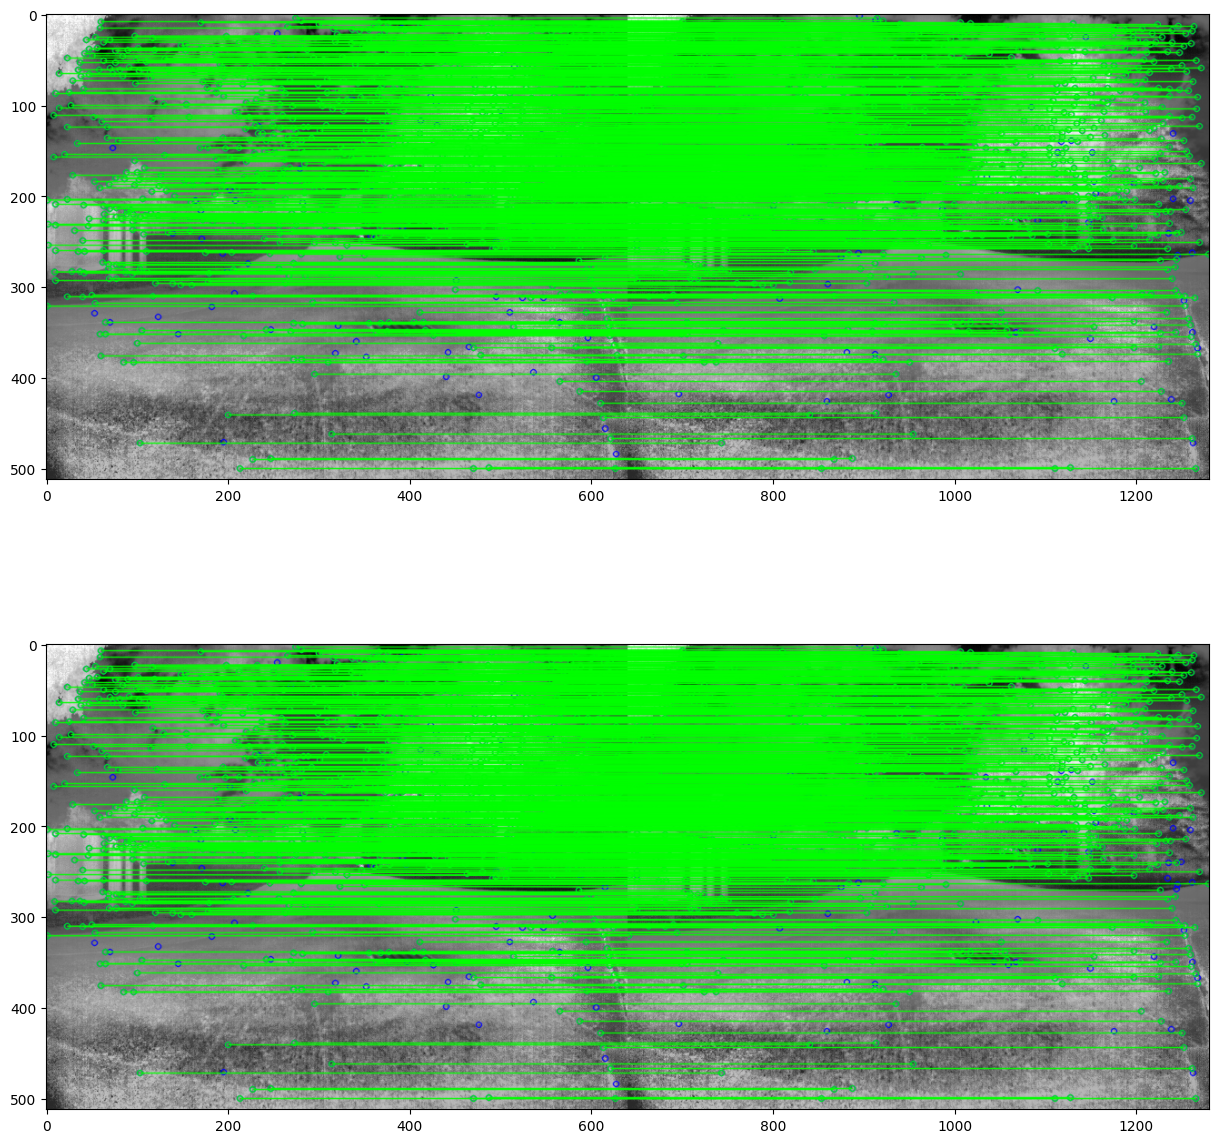

In [546]:
import numpy as np
#cv2 bf matcher on matched kp
desc0, desc1 = pred['descriptors0'].T, pred['descriptors1'].T

# print(kp0.shape)
# print(desc0.shape)
keypoints0 = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kp0]
keypoints1 = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kp1]

# kpim = cv2.drawKeypoints(img0, keypoints0, None)
# plt.imshow(kpim)

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(desc0, desc1)
print("BF found {} matches".format(len(matches)))
matched_img = cv2.drawMatches(img0, keypoints0, img1, keypoints1, matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))
matches_idx = np.array([m.queryIdx for m in matches])
m_kp0 = [keypoints0[idx] for idx in matches_idx]
matches_idx = np.array([m.trainIdx for m in matches])
m_kp1 = [keypoints1[idx] for idx in matches_idx]

matched_pts0 = cv2.KeyPoint_convert(m_kp0)
matched_pts1 = cv2.KeyPoint_convert(m_kp1)
# print(type(matched_pts1))
# matched_pts0 = np.array([[kp.pt[1], kp.pt[0]] for kp in m_kp0])
# matched_pts1 = np.array([[kp.pt[1], kp.pt[0]] for kp in m_kp1])
F, inliers = cv2.findFundamentalMat(matched_pts0[:, [1, 0]],
                                    matched_pts1[:, [1, 0]],
                                    cv2.RANSAC)
inliers = inliers.flatten()
print("{} matches after ransac".format(np.sum(inliers)))
inlier_matches = np.array(matches)[inliers.astype(bool)].tolist()
matched_img_ransac = cv2.drawMatches(img0, keypoints0, img1, keypoints1, inlier_matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,15))
_= ax1.imshow(matched_img)
_ = ax2.imshow(matched_img_ransac)

(795, 2)
(797, 256)
(795, 2)
(795, 256)
(797,)

[  0.8645233 269.30582  ]
Found 795 similar points


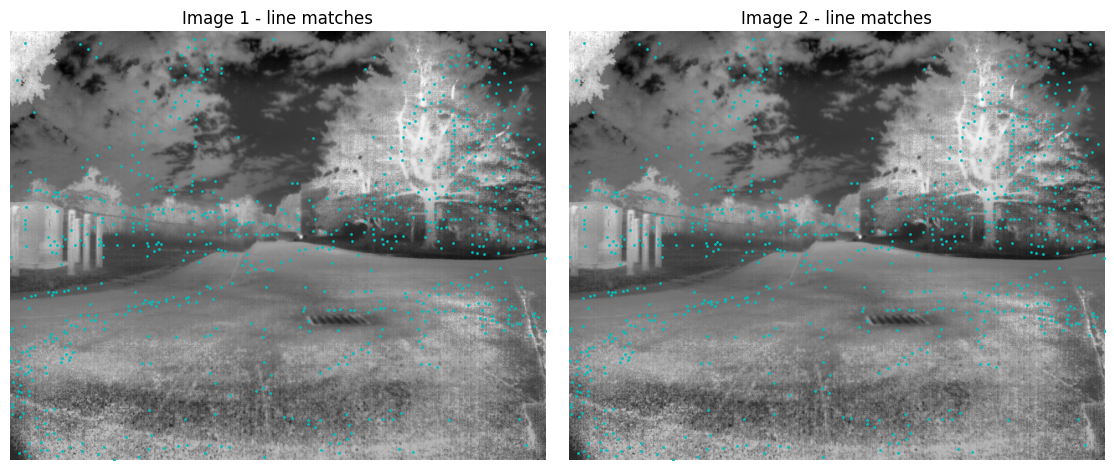

In [547]:
#test save descriptors
kp0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/keypoints/1689804908243000031.npy" 
kp0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/keypoints/1689804908309999943.npy"
kp1 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/keypoints/1689804908309999943_.npy"
desc0 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/descriptors/1689804908243000031.npy"
desc1 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/descriptors/1689804908309999943.npy"
# desc1 = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/descriptors/1689804908309999943_.npy"
matches = "/media/colin/box_data/ir_data/nuance_data/kri_day_2/cam_3/matlab_clahe2/gluestick/matches/1689804908243000031_1689804908309999943.npy"
kp0 = np.load(kp0)
kp1 = np.load(kp1)
desc0 = np.load(desc0)
desc1 = np.load(desc1)
matches = np.load(matches)
print(kp0.shape)
print(desc0.shape)
print(kp1.shape)
print(desc1.shape)
print(matches.shape)
print("")
print(kp0[0])
count = 0
for kp in kp0:
    for k in kp1:
        if np.linalg.norm(k-kp) < 1:
            count += 1
            continue
print("Found {} similar points".format(count))

plot_images([img0, img1], ['Image 1 - line matches', 'Image 2 - line matches'], pad=0.5)
plot_keypoints([kp0, kp1], colors='c')